In [9]:
import torch
import gpytorch
import numpy as np
import optuna
import matplotlib.pyplot as plt
from src.plotting import plot_gp, plot_alpha_beta, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ExactGPModel, BetaGP
from optuna.visualization import plot_optimization_history, plot_param_importances

In [10]:
# set seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 15
RADIUS = 0.6
COORDS = (52.2, -0.25)
IDX = 0

/Users/eirikbaekkelund/Desktop/UCL/Code
==> Loading data
==> Loaded data in: 0 m : 13 sec

/Users/eirikbaekkelund/Desktop/UCL/Code
==> Loading data
==> Loaded data in: 0 m : 0 sec



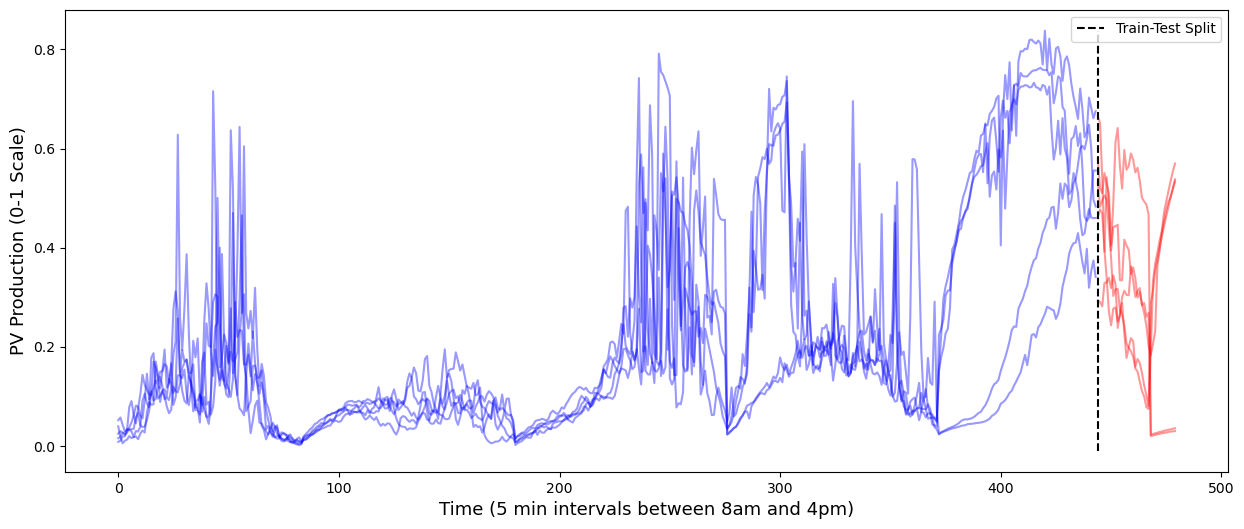

In [3]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=3)
plot_train_test_split(y_train, y_test)

In [4]:

def periodic_mapping(time_steps, day_min, day_max, minute_interval):
    """ 
    Create a periodic mapping of time steps to a sine function to 
    capture the periodicity of the data.

    Args:
        time_steps (torch.Tensor): time steps to map
        day_min (int): minimum time of the day
        day_max (int): maximum time of the day
        minute_interval (int): interval between time steps in minutes

    Returns:
        torch.Tensor: mapped time steps to sine function
    """
    total_minutes = (day_max - day_min) * 60  # Total number of minutes in the specified time range
    normalized_minutes = (time_steps * minute_interval) % total_minutes  # Normalize time steps to minutes

    # Apply periodic mapping using sine function
    mapped_values = torch.sin(2 * torch.pi * normalized_minutes / total_minutes)
    
    return mapped_values

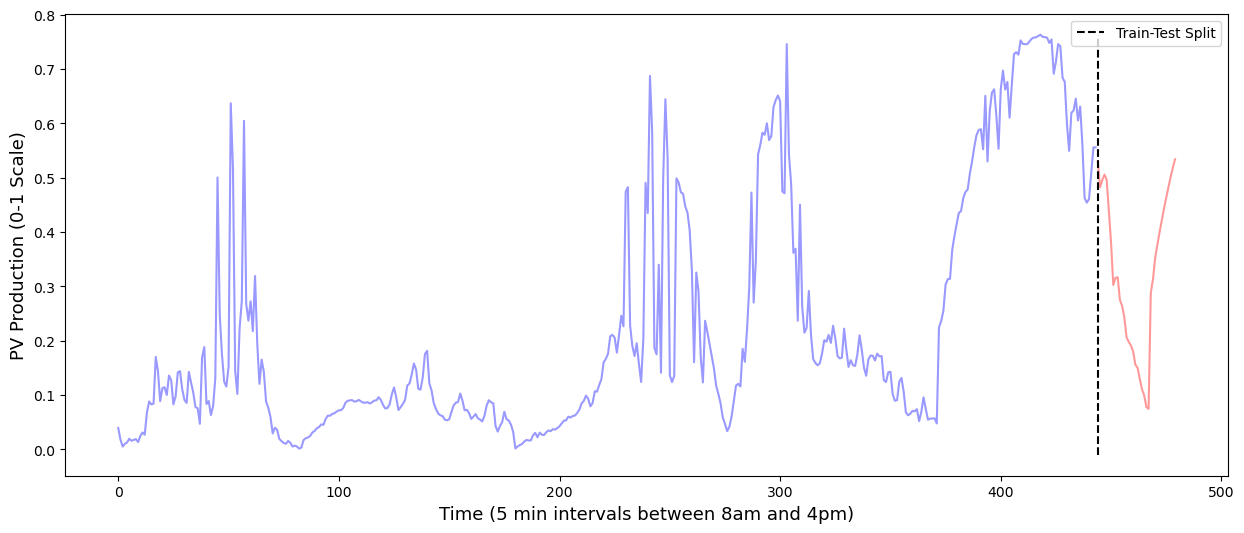

In [5]:
# get individual time series
y_in = y[:, IDX]

if y_in.max() > 1:
    y_in[y_in > 1] = 1
# get time related variables
periodic_time = periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize input
x = (x - x.mean(dim=0)) / x.std(dim=0)

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=3)

plot_train_test_split(y_train, y_test)

# use all data as inducing points
x_inducing = x_train
y_inducing = y_train

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

In [80]:
from gpytorch.distributions import base_distributions
class BetaLikelihood_MeanParametrization(gpytorch.likelihoods.BetaLikelihood):
	
	def forward(self, function_samples, *args, **kwargs):
		# mixture = torch.tanh(function_samples) / 2 + 0.5
		mixture = torch.distributions.Normal(0, 1).cdf(function_samples)		
		self.scale = 80
		
		self.alpha = mixture * self.scale
		self.beta = self.scale - self.alpha

		eps = 1e-9
		
		self.alpha = self.alpha + eps
		self.beta = self.beta + eps
	
		return base_distributions.Beta(concentration1=self.alpha, concentration0=self.beta)

# Kernels

In [81]:
from gpytorch.kernels import MaternKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the lengthscale in matern, and the period in periodic
# BEST INITS
# matern = MaternKernel(nu=5/2, ard_num_dims=x.shape[1], lengthscale_prior=gpytorch.priors.NormalPrior(1, 0.1))
# kernel = ScaleKernel(matern, lengthscale_prior=gpytorch.priors.NormalPrior(0.5, 0.2))

matern = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.NormalPrior(0.5582, 0.05),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
scaled_matern = ScaleKernel(matern, 
                            outputscale_prior=gpytorch.priors.NormalPrior(0.2, 0.058),
                            outputscale_constraint=gpytorch.constraints.Positive()
                            )

In [82]:
jitter = 1e-5
config = {'type': 'stochastic',
          'name': 'mean_field',
          'num_inducing_points': x_inducing.size(0),
          'mean_init_std': 1,
}

inputs_mean = {'X': x_train, 'y': y_train, 
               'mean_module': gpytorch.means.ConstantMean(),
               'covar_module': scaled_matern,
               'likelihood': BetaLikelihood_MeanParametrization(scale_prior=gpytorch.priors.NormalPrior(55, 1),
                                                                scale_constraint=gpytorch.constraints.Interval(20, 200)),
                'config': config,
                'jitter': jitter
            }

model_beta = BetaGP(**inputs_mean)
model_beta.fit(n_iter=400, lr=0.4345, optim=torch.optim.Adam, device=torch.device('cpu'))


Iter 40/400 - Loss: 2.022
Iter 80/400 - Loss: 0.271
Iter 120/400 - Loss: -0.065
Iter 160/400 - Loss: -0.166
Iter 200/400 - Loss: -0.208
Iter 240/400 - Loss: -0.224
Iter 280/400 - Loss: -0.230
Iter 320/400 - Loss: -0.233
Iter 360/400 - Loss: -0.233
Iter 400/400 - Loss: -0.234


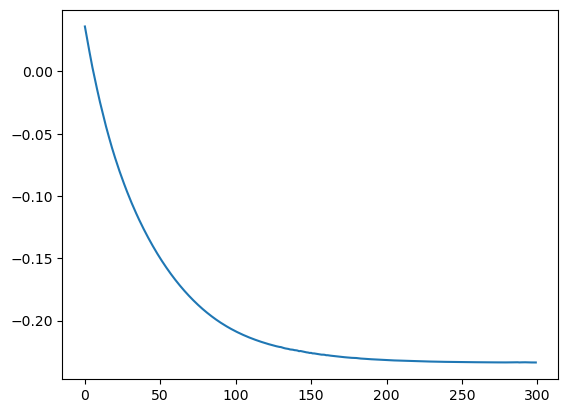

In [83]:
plt.plot(model_beta.losses[100:]);

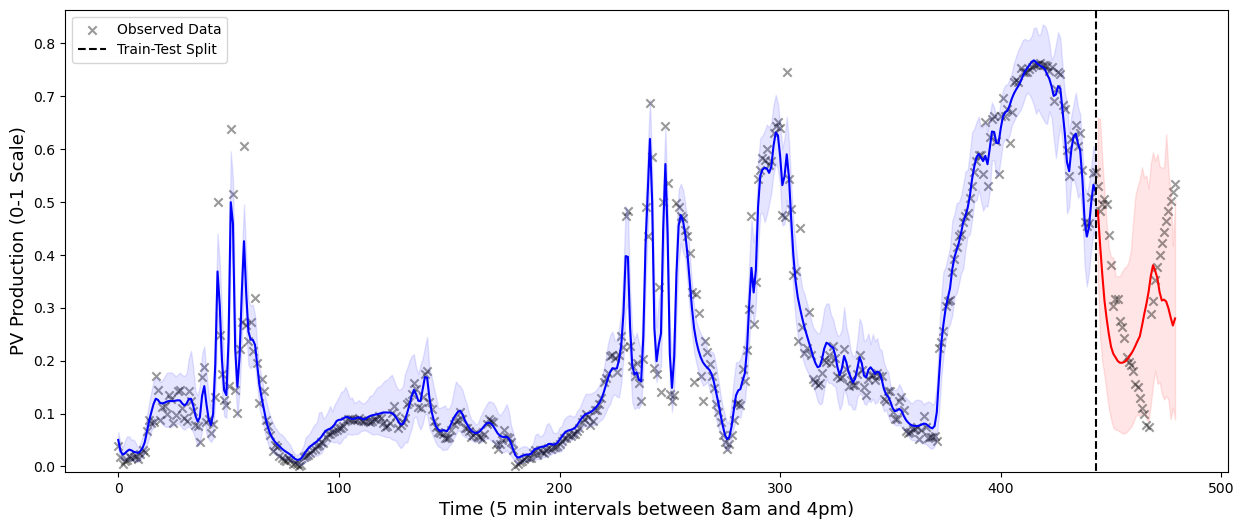

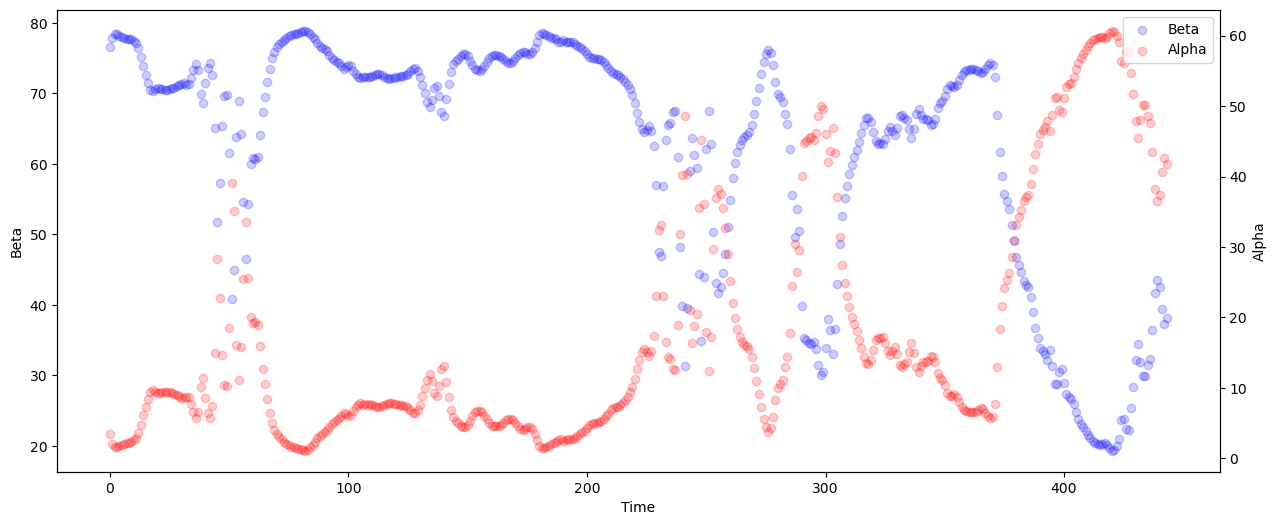

In [84]:
plot_gp(model=model_beta, 
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        y_inducing=y_inducing,
        )

model_beta.predict(x_train, device=torch.device('cpu'))
plot_alpha_beta(model_beta)

# Hyperparameter Optimization

In [66]:
class HyperParameterOptimization:
    """ 
    Hyperparameter optimization using Optuna.

    Args:
        model (gpytorch.models.Model): model to optimize
        x_train (torch.Tensor): training inputs
        y_train (torch.Tensor): training targets
        x_test (torch.Tensor): test inputs
        y_test (torch.Tensor): test targets
    """

    def __init__(self, 
                 model : str,
                 x_train : torch.Tensor,
                 y_train : torch.Tensor,
                 x_test : torch.Tensor,
                 y_test : torch.Tensor,
                ):
        assert model in ['beta', 'exact']
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def sample_params_matern(self,
                             trial : optuna.trial.Trial
                             ):
        """ 
        Sample hyperparameters for the model.

        Args:
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            dict: dictionary of hyperparameters
        """
        # sample hyperparameters
        matern_nu = trial.suggest_categorical('matern_nu', [3/2, 5/2])
        
        lengthscale_mean = trial.suggest_float('lengthscale_mean', 0.1, 5)
        lengthscale_variance = trial.suggest_float('lengthscale_variance', 0.01, 1)

        signal_var_mean = trial.suggest_float('signal_var_mean', 0.1, 0.5, step=0.1)
        signal_var_variance = trial.suggest_float('signal_var_variance', 0.01, 0.1)
        # create kernel
        matern = MaternKernel(nu=matern_nu,
                              lengthscale_prior=gpytorch.priors.NormalPrior(lengthscale_mean, lengthscale_variance),
                              lengthscale_constraint=gpytorch.constraints.Positive()
                                )
        scaled_matern = ScaleKernel(matern,
                                    outputscale_prior=gpytorch.priors.NormalPrior(signal_var_mean, signal_var_variance),
                                    outputscale_constraint=gpytorch.constraints.Positive()
                                    )
        return scaled_matern
    
    def sample_params_likelihood(self,
                                 trial : optuna.trial.Trial
                                ):
        """
        Sample hyperparameters for the likelihood.

        Args:
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            likelihood (gpytorch.likelihoods.Likelihood): likelihood of the model
        """
        likelihood_scale = trial.suggest_float('likelihood_scale', 25, 150, step=5)
        likelihood = BetaLikelihood_MeanParametrization(scale_prior=gpytorch.priors.NormalPrior(likelihood_scale, 1))

        return likelihood                                      

    def get_config(self,
                   config : dict,
                   kernel : gpytorch.kernels.Kernel,
                   likelihood : gpytorch.likelihoods.Likelihood,
                   jitter : float):
        """
        Get the configuration of the model.

        Args:
            config (dict): configuration of the model
            kernel (gpytorch.kernels.Kernel): kernel of the model
            likelihood (gpytorch.likelihoods.Likelihood): likelihood of the model
            jitter (float): jitter for the cholesky decomposition
        
        Returns:
            inputs (dict): dictionary of inputs for the model
        """
        config = {
            'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': self.x_train.size(0),
            # TODO maybe change mean_init_std to a prior
            'mean_init_std': 1,
        }

        inputs = {
            'X': self.x_train,
            'y': self.y_train,
            'mean_module': gpytorch.means.ConstantMean(),
            'covar_module': kernel,
            'likelihood': likelihood,
            'config': config,
            'jitter': jitter
        }

        return inputs
    

    def train(self,
              inputs : dict,
              trial : optuna.trial.Trial
              ):
        """ 
        Train the model with the sampled hyperparameters.

        Args:
            inputs (dict): dictionary of inputs for the model
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            float: negative log likelihood
        """
        if self.model == 'beta':
            model = BetaGP(**inputs)
        elif self.model == 'exact':
            model = ExactGPModel(**inputs)
        
        #n_iter = trial.suggest_int('n_iter', 100, 500, step=100)
        lr = trial.suggest_float('lr', 0.01, 0.5)

        model.fit(n_iter=300, lr=lr, optim=torch.optim.Adam, device=torch.device('cpu'))
        model.predict(self.x_test, device=torch.device('cpu'))

        

        # TODO change return to GPYtorch metric
        return model.losses[-1]
        
    def objective(self,
                  trial : optuna.trial.Trial,
                  config : dict,
                  jitter : float
                 ):
        """ 
        Objective function for Optuna.

        Args:
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            # TODO change to GPyTorch metric
            float: negative log likelihood
        """
        kernel = self.sample_params_matern(trial)
        likelihood = self.sample_params_likelihood(trial)
        inputs = self.get_config(config, kernel, likelihood, jitter)
        
        try:
            inputs = self.get_config(config, kernel, likelihood, jitter)
            loss = self.train(inputs, trial)
        
        # if not PSD we except the trial and add jitter and try again
        except:
            inputs = self.get_config(config, kernel, likelihood, jitter*10)
            loss = self.train(inputs, trial)

        return loss

In [67]:
 config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-5

In [ ]:
hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter), n_trials=100)

In [69]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_edf, plot_parallel_coordinate, plot_param_importances, plot_slice, plot_intermediate_values

In [70]:
plot_optimization_history(study)

In [71]:
plot_contour(study, params=[ 'likelihood_scale', 'lengthscale'])

In [72]:
plot_parallel_coordinate(study)

In [73]:
plot_param_importances(study)

In [74]:
best_params = study.best_params
best_params

{'matern_nu': 1.5,
 'lengthscale': 0.5582339381459845,
 'signal_var_mean': 0.2,
 'signal_var_variance': 0.08042051367009091,
 'likelihood_scale': 55.0,
 'lr': 0.4345839148228726}

In [ ]:
lr = best_params['lr']
lengths